C:\Users\g3rm4\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,387 (462.45 KB)

 Trainable params: 118,003 (460.95 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/300
109/109 - 10s - 95ms/step - loss: 0.2502 - mae: 0.3596 - val_loss: 0.1636 - val_mae: 0.3576 - learning_rate: 0.0010
Epoch 2/300
109/109 - 5s - 43ms/step - loss: 0.0987 - mae: 0.2357 - val_loss: 0.1121 - val_mae: 0.3084 - learning_rate: 0.0010
Epoch 3/300
109/109 - 5s - 45ms/step - loss: 0.0508 - mae: 0.1620 - val_loss: 0.0429 - val_mae: 0.1457 - learning_rate: 0.0010
Epoch 4/300
109/109 - 5s - 43ms/step - loss: 0.0391 - mae: 0.1305 - val_loss: 0.0524 - val_mae: 0.1892 - learning_rate: 0.0010
Epoch 5/300
109/109 - 5s - 42ms/step - loss: 0.0305 - mae: 0.1146 - val_loss: 0.1976 - val_mae: 0.4036 - learning_rate: 0.0010
Epoch 6/300
109/109 - 5s - 43ms/step - loss: 0.0238 - mae: 0.0996 - val_loss: 0.0468 - val_mae: 0.1903 - learning_rate: 0.0010
Epoch 7/300
109/109 - 5s - 43ms/step - loss: 0.0171 - mae: 0.0863 - val_loss: 0.0094 - val_mae: 0.0646 - learning_rate: 0.0010
Epoch 8/300
109/109 - 5s - 42ms/step - loss: 0.0114 - mae: 0.0717 - val_loss: 0.0159 - val_mae: 0.1030 - learn

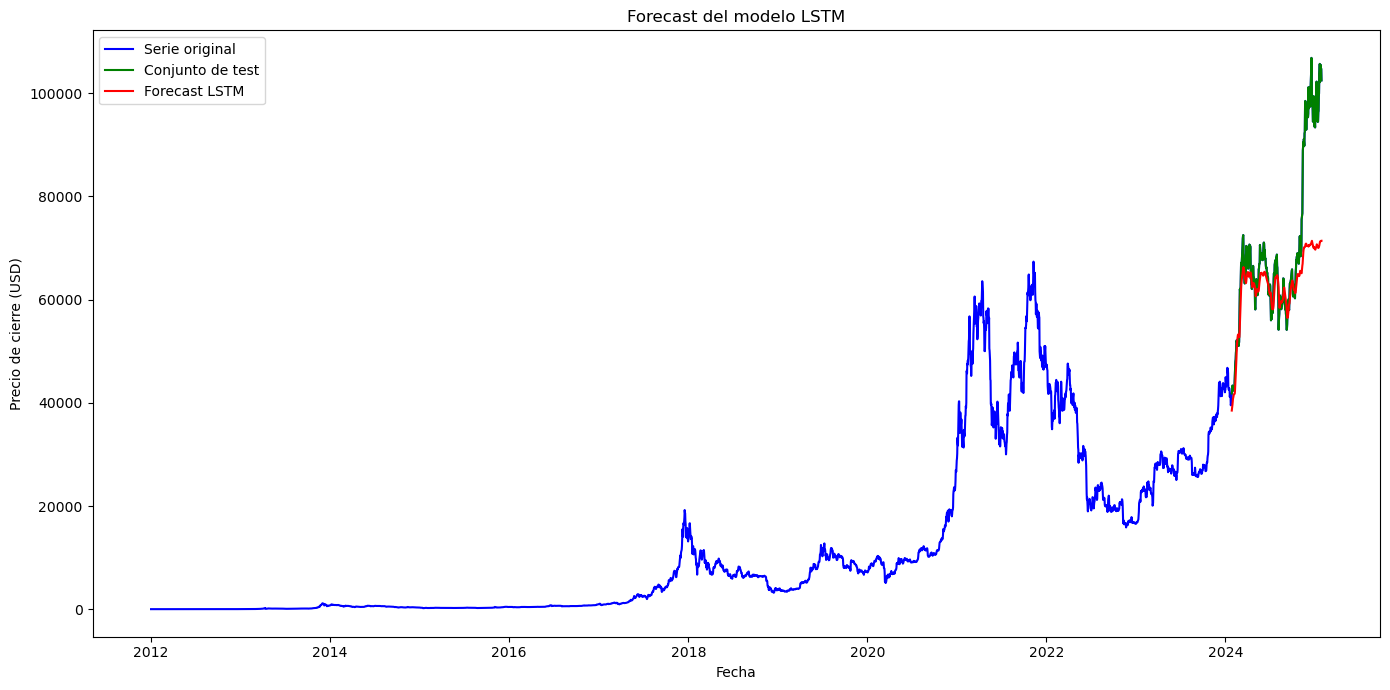

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Cargar y limpiar los datos
df_raw = pd.read_csv('btcusd_1-min_data.csv').dropna()
df_raw['Timestamp'] = pd.to_datetime(df_raw['Timestamp'], unit='s')
df_raw.set_index('Timestamp', inplace=True)

# 2. Agregación diaria
data_day = df_raw['Close'].resample('D').mean().ffill()
df = pd.DataFrame(data_day, columns=['Close'])

# 3. Split train/test (último año)
split_date = df.index.max() - pd.DateOffset(years=1)
train_df = df.loc[:split_date].copy()
test_df  = df.loc[split_date:].copy()

# 4. Escalado
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_df[['Close']])
train_scaled = scaler.transform(train_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])

# 5. Crear secuencias
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60

# 5a. Secuencias de entrenamiento
X_train, y_train = create_sequences(train_scaled, seq_length)
X_train = X_train.reshape((len(X_train), seq_length, 1))

# 5b. Secuencias de test (con contexto de los últimos `seq_length` de train)
full_scaled = np.vstack([train_scaled[-seq_length:], test_scaled])
X_test, y_test  = create_sequences(full_scaled, seq_length)
X_test = X_test.reshape((len(X_test), seq_length, 1))

# 6. Definir modelo LSTM mejorado
def build_model(input_shape):
    m = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64),
        BatchNormalization(),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return m

model = build_model((seq_length, 1))
model.summary()

# 7. Callbacks
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

# 8. Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[es, rlr],
    verbose=2
)

# 9. Predicción batch sobre todo X_test
pred_scaled = model.predict(X_test, verbose=0).flatten()
predicted_prices = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()

# 10. Alinear índices (cada predicción corresponde a cada día de test_df)
pred_index = test_df.index

# 11. Métricas
real_prices = test_df['Close'].values
mae  = mean_absolute_error(real_prices, predicted_prices)
mape = mean_absolute_percentage_error(real_prices, predicted_prices) * 100
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# 12. Gráfica final
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'],              label='Serie original', color='blue')
plt.plot(test_df.index, test_df['Close'],     label='Conjunto de test', color='green')
plt.plot(pred_index, predicted_prices,        label='Forecast LSTM', color='red')
plt.title('Forecast del modelo LSTM')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre (USD)')
plt.legend()
plt.tight_layout()
plt.savefig("Forecast_LSTM.png")
plt.show()
